In [2]:
# imports
from astropy.table import QTable
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
import os
import math
import shutil
from IPython.core.debugger import Tracer
import subprocess
import re
%matplotlib inline

4079 20921 25000
4079 20921 25000


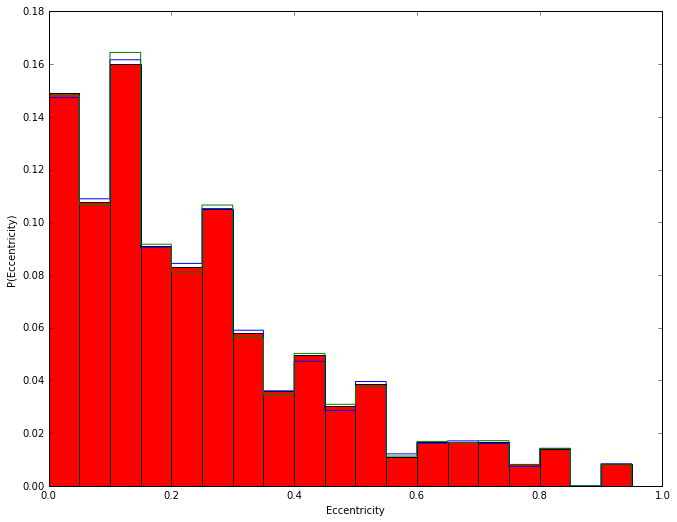

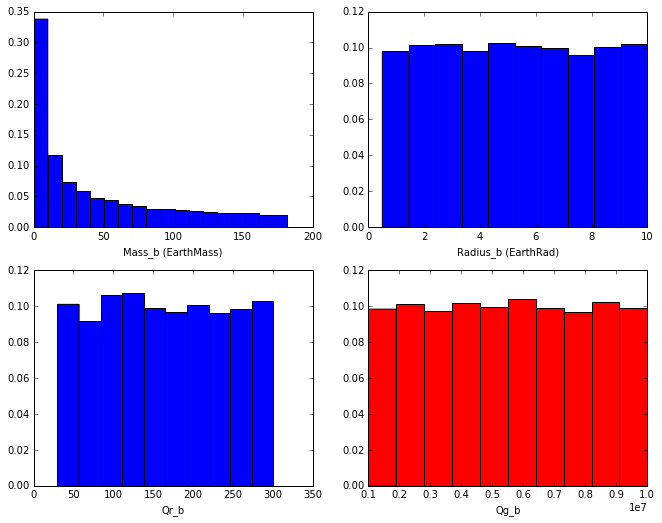

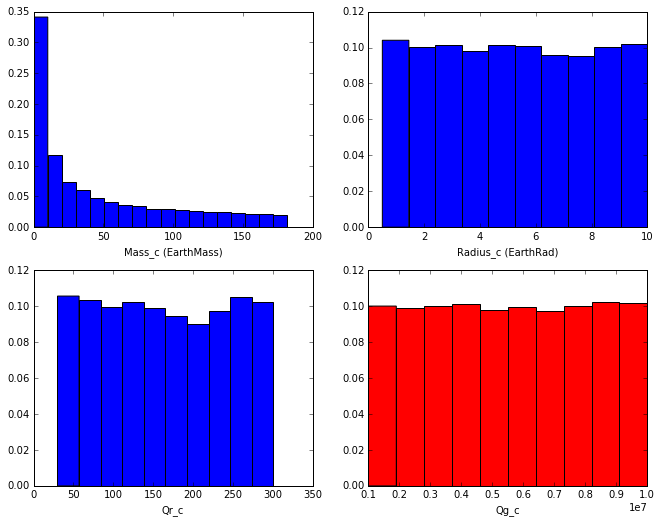

In [17]:
#produces eccentricity distribution from Kepler
#generates mass,rad,ecc,semi,Qp, for b,c, and star
#ALL NOT HILL STABLE

data = QTable.read('probecc_comma.dat',format='ascii.no_header')

data.rename_column('col1','ecc')
data.rename_column('col2','% in bin')
data.rename_column('col3','cum %')
x = np.arange(0,1,0.05)
y = data['cum %']
ecc_inbin = data['% in bin']
cum=data['cum %']
binwidth = 0.05
fig,ax=plt.subplots(1,1)
fig.set_size_inches(11,8.5)                  

bar = ax.bar(data['ecc'],ecc_inbin,width=0.05,color='r')
ax.set_xlabel('Eccentricity')
ax.set_ylabel('P(Eccentricity)')

# generates a distribution of 't' eccentricities fitted to the kepler distribution
def ecc_gen(t): # t = number of simulations
    n = 0
    ecc_list = np.array([])
    while n <= t-1:
        r = (np.random.sample(1)) #some y value (percentage)
        if r <= 0.149171270718232:
            bin_lower=0.0
            bin_upper=0.05
        else:
            r_mask = np.where(y<=r)
            x_below = x[r_mask]
            x_below = np.append(x_below,x_below[-1]+0.05)
            bin_upper = x_below[-1]+0.05
            bin_lower = x_below[-2]+0.05
        rand = np.random.uniform(0,0.05,1)
        ecc = bin_lower + rand 
        ecc_list=np.append(ecc_list,ecc)
        n += 1
        continue
    return ecc_list

# function to calc mass and Q based on radius; call for b.in and c.in
def calc_mass_Qp(radius,toggle):
    r = radius
    R_crit = 2*u.earthRad
    if r < R_crit:
        mass = ((r/const.R_earth)**(3.68))*const.M_earth
        mass = mass.to(u.earthMass)
        Qplanet = np.random.uniform(30,301)
    else:
        r = r.to(u.cm)
        volume = (4*np.pi*r**3)/3
        density = (1*u.g)/(1*u.cm)**3
        mass = volume * density
        mass = mass.to(u.earthMass)
        Qplanet = np.random.uniform(10**6,(10**7)+1)
    if toggle == 'm':
        return mass
    elif toggle == 'Q':
        return Qplanet


t = 25000 # number of sims

ecc_b = ecc_gen(t)
ecc_c = ecc_gen(t)

ecc_hist_b = ax.hist(ecc_b,bins=x,weights=np.zeros_like(ecc_b)+1./ecc_b.size,histtype='step',color='blue')
ecc_hist_c = ax.hist(ecc_c,bins=x,weights=np.zeros_like(ecc_c)+1./ecc_c.size,histtype='step',color='green')



# now to generate ICs and their files. 
# clears vars and generates new randoms

# b.in
ecc_b = ecc_b
rad_b = np.random.uniform(0.5,10,25000) * u.earthRad # [0.5,10] R_earth;  
mass_b = np.array([]) #if radius < 2 R_earth, then mass = ((R/R_earth)**(3.68))*M_earth; if larger, density = 1g/cm**3
Qp_b = np.array([])    # [30,300] # [10**6,10**7]
for r in rad_b:
    m = calc_mass_Qp(r,'m')
    mass_b = np.append(mass_b,m) 
    q = calc_mass_Qp(r,'Q')
    Qp_b = np.append(Qp_b,q)
semi_b = np.random.uniform(0.01,0.15,25000) # [0.01,0.15] AU

# c.in
ecc_c = ecc_c
rad_c = np.random.uniform(0.5,10,25000) * u.earthRad
mass_c = np.array([])
Qp_c = np.array([])
for r in rad_c:
    m = calc_mass_Qp(r,'m')
    mass_c = np.append(mass_c,m) 
    q = calc_mass_Qp(r,'Q')
    Qp_c = np.append(Qp_c,q)
semi_c = np.array([])

# makes sure semi_c is always > semi_b
for a_b in semi_b:
    a_c = np.random.uniform(a_b,0.5,1)
    semi_c = np.append(semi_c,a_c)

# star.in
stellar_mass = np.random.uniform(0.7,1.4,25000) # [0.7,1.4] M_sun
stellar_radius = np.random.uniform(0.7,1.4,25000) #[0.7,1.4] R_sun
Qstar = np.random.uniform(10**6,10**7,25000) # [10**6,10**7]

#vpl.in
Ages = 10e09

#convert to values so its easy to write to file
rad_b = rad_b.value
rad_c = rad_c.value
mass_b = mass_b.value
mass_c = mass_c.value

#graphs of b.in parameters        
fig,ax = plt.subplots(2,2)
fig.set_size_inches(11,8.5)
ran = max(mass_b)-min(mass_b)
ax[0,0].hist(mass_b,bins=18,weights=np.zeros_like(mass_b)+1./mass_b.size) # 18 bins --> binwidth ~10 earthMass
ax[0,1].hist(rad_b,weights=np.zeros_like(rad_b)+1./rad_b.size) # Uniform
q_lower = np.where(Qp_b<=301)
q_upper = np.where(Qp_b>301) 
ax[1,0].hist(Qp_b[q_lower],weights=np.zeros_like(Qp_b[q_lower])+1./Qp_b[q_lower].size) 
ax[1,1].hist(Qp_b[q_upper],weights=np.zeros_like(Qp_b[q_upper])+1./Qp_b[q_upper].size,color='r')

ax[0,0].set_xlabel('Mass_b (EarthMass)')
ax[0,1].set_xlabel('Radius_b (EarthRad)')
ax[1,0].set_xlabel('Qr_b')
ax[1,1].set_xlabel('Qg_b')

#graphs of c.in parameters
# distributions for c.in of mass, Qp, Radius. 
fig,ax = plt.subplots(2,2)
fig.set_size_inches(11,8.5)
ran = max(mass_c)-min(mass_c)
ax[0,0].hist(mass_c,bins=18,weights=np.zeros_like(mass_c)+1./mass_c.size) # 18 bins --> binwidth ~10 earthMass
ax[0,1].hist(rad_c,weights=np.zeros_like(rad_c)+1./rad_c.size) # Uniform
q_lower = np.where(Qp_c<=301)
q_upper = np.where(Qp_c>301) 
ax[1,0].hist(Qp_c[q_lower],weights=np.zeros_like(Qp_c[q_lower])+1./Qp_c[q_lower].size) 
ax[1,1].hist(Qp_c[q_upper],weights=np.zeros_like(Qp_c[q_upper])+1./Qp_c[q_upper].size,color='r')

ax[0,0].set_xlabel('Mass_c (EarthMass)')
ax[0,1].set_xlabel('Radius_c (EarthRad)')
ax[1,0].set_xlabel('Qr_c')
ax[1,1].set_xlabel('Qg_c')

print(Qp_c[q_lower].size,Qp_c[q_upper].size,Qp_c[q_lower].size + Qp_c[q_upper].size)

print(Qp_b[q_lower].size,Qp_b[q_upper].size,Qp_b[q_lower].size + Qp_b[q_upper].size)


In [23]:
#shutil.rmtree('./runs/')

#fills the following lists:
hill_list = np.array([])
mean_an_b = np.array([])
mean_an_c = np.array([])
incl_b = np.array([])
incl_c = np.array([])
longa_b = np.array([])
longa_c = np.array([])
argp_b = np.array([])
argp_c = np.array([])

good_hill_list = np.array([])
bad_hill_list = np.array([])
bad_count = 0 

n = 0
while n <= t-1:
    name_idx = '%05i'%n
    os.makedirs('./runs/'+name_idx)
    #semi_c_0 = np.array([])
    
    while True:
        #hill.in
        
        if bad_count == 2:
            #semi_c_0 = np.append(semi_c_0,semi_c[n])
            semi_c[n] = semi_c[n] + 0.01
            bad_count = 0 # increases outer mass, should that increase hill stability? 
        inc_b = 0
        inc_c = np.random.uniform(0,20)
        longasc_b = np.random.uniform(0,360)
        longasc_c = np.random.uniform(0,360)
        argperi_b = np.random.uniform(0,360)
        argperi_c = np.random.uniform(0,360)
        mean_an_b = np.random.uniform(0,360)
        mean_an_c = np.random.uniform(0,360)
        
        innermass_str = str(mass_b[n])
        outermass_str = str(mass_c[n])
        strMass_str = str(stellar_mass[n])
        semi_str_b = str(semi_b[n])
        semi_str_c = str(semi_c[n])
        ecc_str_b = str(ecc_b[n])
        ecc_str_c = str(ecc_c[n])
        
        incl_str_b = str(inc_b)
        incl_str_c = str(inc_c)
        longasc_str_b = str(longasc_b)
        longasc_str_c = str(longasc_c)
        argperi_str_b = str(argperi_b)
        argperi_str_c = str(argperi_c)
        mean_an_str_b = str(mean_an_b)
        mean_an_str_c = str(mean_an_c)
    
        hill = open('./runs/'+name_idx+'/hill.in','w')
        hill_content = (strMass_str+'\n'
                        +innermass_str+' '+semi_str_b+' '+ecc_str_b+' '+incl_str_b+' '+argperi_str_b+' '+longasc_str_b+' '+mean_an_str_b+'\n'
                        +outermass_str+' '+semi_str_c+' '+ecc_str_c+' '+incl_str_c+' '+argperi_str_c+' '+longasc_str_c+' '+mean_an_str_c+'\n'
                        +'body\n')
        hill.write(hill_content)
        hill.close()
    
        wd = './runs/'+name_idx
        hill = subprocess.call(['hillstab hill.in > hill_log'], shell=True, cwd = wd )
        hill_log = open(wd+'/hill_log','r')
        hill_content = hill_log.read()
        hill_content = hill_content.split()
        hill_exact = hill_content[1]
        hill_exact = float(hill_exact)
        if hill_exact < 1: # push out semi so that hill stab > 1
            bad_count += 1
            continue
        elif hill_exact >= 1:
            hill_list = np.append(hill_list,hill_exact)
            incl_b = np.append(incl_b,incl_b)
            incl_c = np.append(incl_c,incl_c)
            longa_b = np.append(longa_b,longasc_b)
            longa_c = np.append(longa_c,longasc_c)
            argp_b = np.append(argp_b,argperi_b)
            argp_c = np.append(argp_c,argperi_c)
            mean_an_b_list = np.append(mean_an_b_list,mean_an_b)
            mean_an_c_list = np.append(mean_an_c_list,mean_an_c)
            good_hill_list = np.append(good_hill_list,name_idx)
            break
        
    n += 1
print('Hill Stability determined')


Hill Stability determined


In [13]:
rad_b[0]

6.870523470094219

In [16]:
r = 4.04165537954 *u.earthRad
m = calc_mass_Qp(r,'m')
m

<Quantity 12.010691639142062 earthMass>